In [4]:
from example.discretizer.utils import IsTrafficLightNearby, StopAreaNearby, FrontObjects, IsTwoWheelNearby, Rotation, Velocity, IsZebraNearby, LanePosition, PedestrianNearby, BlockProgress
from pgeon.intention_introspector import IntentionIntrospector
from pgeon.desire import Desire
from example.discretizer.discretizer_d0 import AVDiscretizer
from example.discretizer.discretizer_d1 import AVDiscretizerD1
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
import numpy as np
import matplotlib.pyplot as plt
from typing import Set, Dict, Tuple


## Common initialization (valid for each discretiser)

In [5]:
environment = SelfDrivingEnvironment(city='all')
discretizer_configs = {
    'a': {'obj_discretizer': 'binary', 'vel_discretizer': 'binary' },
    'b': {'obj_discretizer': 'multiple', 'vel_discretizer': 'binary'}
    }

default_config = {'obj_discretizer': 'binary', 'vel_discretizer': 'binary'}
commitment_threshold = 0.5

In [6]:
def roc_curve(discretisers_info: Dict[str, Tuple[PG.PolicyGraph, Set[Desire]]]):
    
    plt.figure(figsize=(10, 6))

    thresholds = np.arange(0, 1, 0.1)

    for discretizer_id, (pg, desires) in discretisers_info.items():
        intention_probabilities = []
        expected_probabilities = []

        for threshold in thresholds:
            print(threshold)
            ii = IntentionIntrospector(desires, pg)

            intention_prob, expected_prob=ii.get_intention_metrics(commitment_threshold=threshold,desire=any)
            intention_probabilities.append(intention_prob)
            expected_probabilities.append(expected_prob)

        plt.plot(intention_probabilities, expected_probabilities, label=f'Discretizer D{discretizer_id}')           

    plt.xlabel('Intention Probability for any desire')
    plt.ylabel('Expected Intention Probability')
    plt.title('Intention Probability vs Expected Intention Probability for any desire')
    plt.legend()
    plt.grid(True)
    plt.show()
    #plt.savefig(f'roc.png', dpi=100)

In [7]:
def show_metrics(metrics_data, discretizer_id, type='Desire'):
    
    """
    Function to show bar plots with metrics for each desire. The metrics can be 
    desire or intention metrics, based on the value of the parameter 'type' (Desire or Intention).
    """
    desires = list(metrics_data.keys())

    fig, ax = plt.subplots(figsize=(55, 15))

    labels = []
    val1 = []
    val2 = []

    for desire in desires:
        if desire == 'any':
            val1.append(metrics_data[desire][0])
            val2.append(metrics_data[desire][1])
        else:
            val1.append(metrics_data[desire][0])
            val2.append(metrics_data[desire][1])
        labels.append(f"{desire}")

    x = np.arange(len(desires))
    width = 0.35

    rects1 = ax.bar(x - width/2, val1, width, label=f'{type} Probability')
    metric_label = 'Expected Action Probability' if type == 'Desire' else 'Expected Intention Probability'
    rects2 = ax.bar(x + width/2, val2, width, label=metric_label)

    ax.set_xlabel(f'Desires', fontsize=45)
    ax.set_ylabel(f'{type}s Metrics', fontsize=45)
    ax.set_title(f'Discretizer D{discretizer_id}', fontsize=50)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=40,rotation = 30)
    
    plt.yticks(fontsize=30)

        
    ax.legend( fontsize=35, loc='upper right' )
    for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=35)

    for rect in rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=35)

    plt.show()  
    #plt.savefig(f'{type}_{discretizer_id}.png', bbox_inches = 'tight')

Desires Iteration 1

In [9]:

any = Desire("any", None, set())

stop_traffic_light = Desire("stop_traffic_light", [1], {IsTrafficLightNearby:  [IsTrafficLightNearby.YES]}) #NOTE: traffic light color can be also green or yellow
stop_stop_sign = Desire("stop_stop_sign", [1], {StopAreaNearby: [StopAreaNearby.STOP]})

stop_zebra = Desire("stop_zebra", [1], {IsZebraNearby: [IsZebraNearby.YES]})
lane_change = Desire("lane_change", [7,8, 2, 3 ], {LanePosition: [LanePosition.CENTER] }) #GAS_TURN_LEFT
turn_at_intersection = Desire("turn_at_intersection", [7,8, 2, 3 ], {BlockProgress: [BlockProgress.INTERSECTION]})
obstacle_avoidance  =Desire("obstacle_avoid", [3,7, 2,8], {FrontObjects: [FrontObjects(1, discretization='binary'), FrontObjects(1, discretization='multiple'), FrontObjects(5, discretization='multiple')]})

desires = [stop_traffic_light, stop_stop_sign, stop_zebra, lane_change, turn_at_intersection, obstacle_avoidance]

Desires Iteration 2

In [76]:
arrive_yield_sign = Desire("arrive_yield_sign", [5, 9, 10], {StopAreaNearby: [StopAreaNearby.YIELD, StopAreaNearby.TURN_STOP], Velocity:[Velocity.MEDIUM, Velocity.HIGH]}) #NOTE: there are no yield signs.#Slow down but not necessarely stop
turn_at_intersection = Desire("turn_at_intersection", [2, 3, 7,8,9,10], {BlockProgress: [BlockProgress.INTERSECTION], Rotation: [Rotation.LEFT, Rotation.RIGHT]})
wait_traffic_light = Desire("wait_traffic_light", [1], {IsTrafficLightNearby:  [IsTrafficLightNearby.YES], Velocity: [Velocity.STOPPED]}) #NOTE: traffic light color can be also green or yellow, you should stop and not only slow down
arrive_traffic_light = Desire("arrive_traffic_light", [5, 9, 10], {IsTrafficLightNearby:  [IsTrafficLightNearby.YES], Velocity: [Velocity.MEDIUM, Velocity.HIGH]}) #if it's green i dont brake even if I have high speed, that's why we get these results.
wait_stop_sign = Desire("wait_stop_sign", [1], {StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.STOPPED]})
stop_sign = Desire("stop_stop_sign", [5, 9, 10,1], {StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.MEDIUM, Velocity.HIGH, Velocity.LOW, Velocity.MOVING]}) #you want to stop, not just slow down.
peds_at_zebra_crossing = Desire("peds_at_zebra_crossing", [5, 9, 10], {IsZebraNearby: [IsZebraNearby.YES], Velocity:[Velocity.MEDIUM, Velocity.HIGH], PedestrianNearby: [PedestrianNearby(1, discretization='binary')]}) #Slow down but not necessarely stop, i.e. when peds are far or already at the end of the zebra or on the other side of the street
two_wheel_presence = Desire('two_wheel_presence', [5,9,10], {IsTwoWheelNearby: [IsTwoWheelNearby.YES], Velocity: [Velocity.MEDIUM, Velocity.HIGH]})
lane_keeping = Desire('lane_keeping', [4,5,6], {LanePosition: [LanePosition.ALIGNED], Rotation: [Rotation.FORWARD], BlockProgress: [BlockProgress.START, BlockProgress.MIDDLE, BlockProgress.END]} ) #not consider intersection

#turn_left = 
#turn_right =

lane_change_to_lf = Desire("lane_change_to_lf", [2,4,8,10], {Rotation: [Rotation.LEFT],LanePosition: [LanePosition.CENTER]}) #we consider also actions inclusing braking since we are not on highways
lane_change_to_rt = Desire("lane_change_to_rt", [3,4,7,9 ], {Rotation: [Rotation.RIGHT],LanePosition: [LanePosition.CENTER]}) 


#overtake = Desire("overtake", [2, 4, 8 ], {Rotation: [Rotation.LEFT],LanePosition: [LanePosition.CENTER], FrontObjects: [FrontObjects(1, discretization='binary')]}) #the view of the front camera is wide enough to capture objects also a bit on the side so we can specify FrontObject
#overtake in left driving country
overtake_left = Desire("overtake_left", [3, 4, 7 ], {Rotation: [Rotation.RIGHT],LanePosition: [LanePosition.CENTER], FrontObjects: [FrontObjects(1, discretization='binary')]}) #the view of the front camera is wide enough to capture objects also a bit on the side so we can specify FrontObject
#overtake in right driving country
overtake_right = Desire("overtake_right", [2,4,8 ], {Rotation: [Rotation.LEFT],LanePosition: [LanePosition.CENTER], FrontObjects: [FrontObjects(1, discretization='binary')]}) #the view of the front camera is wide enough to capture objects also a bit on the side so we can specify FrontObject

#obstacle_avoidance  =Desire("obstacle_avoid", [2,3,7,8,9,10], {Rotation: [Rotation.RIGHT, Rotation.LEFT], LanePosition: [LanePosition.ALIGNED, LanePosition.CENTER], FrontObjects: [FrontObjects(1, discretization='binary')]})
lf_obstacle_avoidance  =Desire("lf_obstacle_avoidance", [2,3,7,8,9,10], {Rotation: [Rotation.RIGHT], LanePosition: [LanePosition.ALIGNED, LanePosition.CENTER], FrontObjects: [FrontObjects(1, discretization='binary')]})
rt_obstacle_avoidance  =Desire("rt_obstacle_avoidance", [2,7,8,9,10], {Rotation: [Rotation.LEFT], LanePosition: [LanePosition.ALIGNED, LanePosition.CENTER], FrontObjects: [FrontObjects(1, discretization='binary')]})


#NOTE: obstacle avoidance has low expected desire probability. this is probabilt due to the vehicle having front objects (other vehicles) and not necessarely wanting to avoid them, maybe just want to turn left and get another road. i should add a predicate like 'closest object type : object, animal, etc'
#NOTE:  Other driving intentions (such as u-turns, emergency lane changes, emergency turning, yielding, curvy road lane changes, lane change preparations, and sharp turning intentions) were excluded due to a limited coverage by the dataset

#desires =[lane_keeping, wait_traffic_light, wait_stop_sign, arrive_traffic_light, stop_sign, peds_at_zebra_crossing, turn_at_intersection, arrive_yield_sign, overtake, obstacle_avoidance,two_wheel_presence ]
desires = [lane_change_to_rt, lane_change_to_lf, overtake_left, overtake_right]



## Discretisers 0a, 0b, 1a, 1b

#### Compute Desires and Intention Metrics


In [77]:
import networkx as nx
intentions_data = {}
desires_data = {}

for discretizer_id in ['0a','0b', '1a','1b']: 
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break


    DiscretizerClass = AVDiscretizer if '0' in discretizer_id else AVDiscretizerD1

    discretizer = DiscretizerClass(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
        ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    print(f'DISCRETIZER {discretizer_id} ')
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    
    weakly_connected_components = list(nx.weakly_connected_components(pg))
    for component in weakly_connected_components:
        if len(component) == 1:
            pg.remove_node(next(iter(component))) 

    
    

    ii = IntentionIntrospector(desires, pg)

    desires_data[discretizer_id] = ii.find_desires() 
    print(desires_data[discretizer_id])
    intentions_data[discretizer_id] = ii.find_intentions( commitment_threshold) #{desire.name: [self.get_intention_metrics(commitment_threshold, desire)] for desire in self.desires}
    intentions_data[discretizer_id]['any']=ii.get_intention_metrics(commitment_threshold,any)
    print(intentions_data[discretizer_id])
    print()

DISCRETIZER 0a 
{'lane_change_to_rt': (0.011513897634253844, 0.7786486887792401), 'lane_change_to_lf': (0.012713261971155288, 0.6566250135708678), 'overtake_left': (0.0009295073610986177, 0.629032258064516), 'overtake_right': (0.0017990465053521634, 0.7134920634920633)}
{'lane_change_to_rt': (0.010614374381577764, 0.8273893596986818), 'lane_change_to_lf': (0.009714851128901681, 0.8281601832440408), 'overtake_left': (0.000509729843183113, 0.764705882352941), 'overtake_right': (0.0015591736379718748, 0.8232600732600731), 'any': (0.02041917783574706, 0.8285164944264353)}

DISCRETIZER 0b 
{'lane_change_to_rt': (0.011513897634253844, 0.7771459734895028), 'lane_change_to_lf': (0.01271326197115529, 0.6563031315250626), 'overtake_left': (0.0009295073610986177, 0.6344086021505377), 'overtake_right': (0.001799046505352163, 0.7144444444444447)}
{'lane_change_to_rt': (0.01049443794788762, 0.8323394018916411), 'lane_change_to_lf': (0.009714851128901683, 0.8339117943939747), 'overtake_left': (0.0005

### Bar Plot

#### Desires

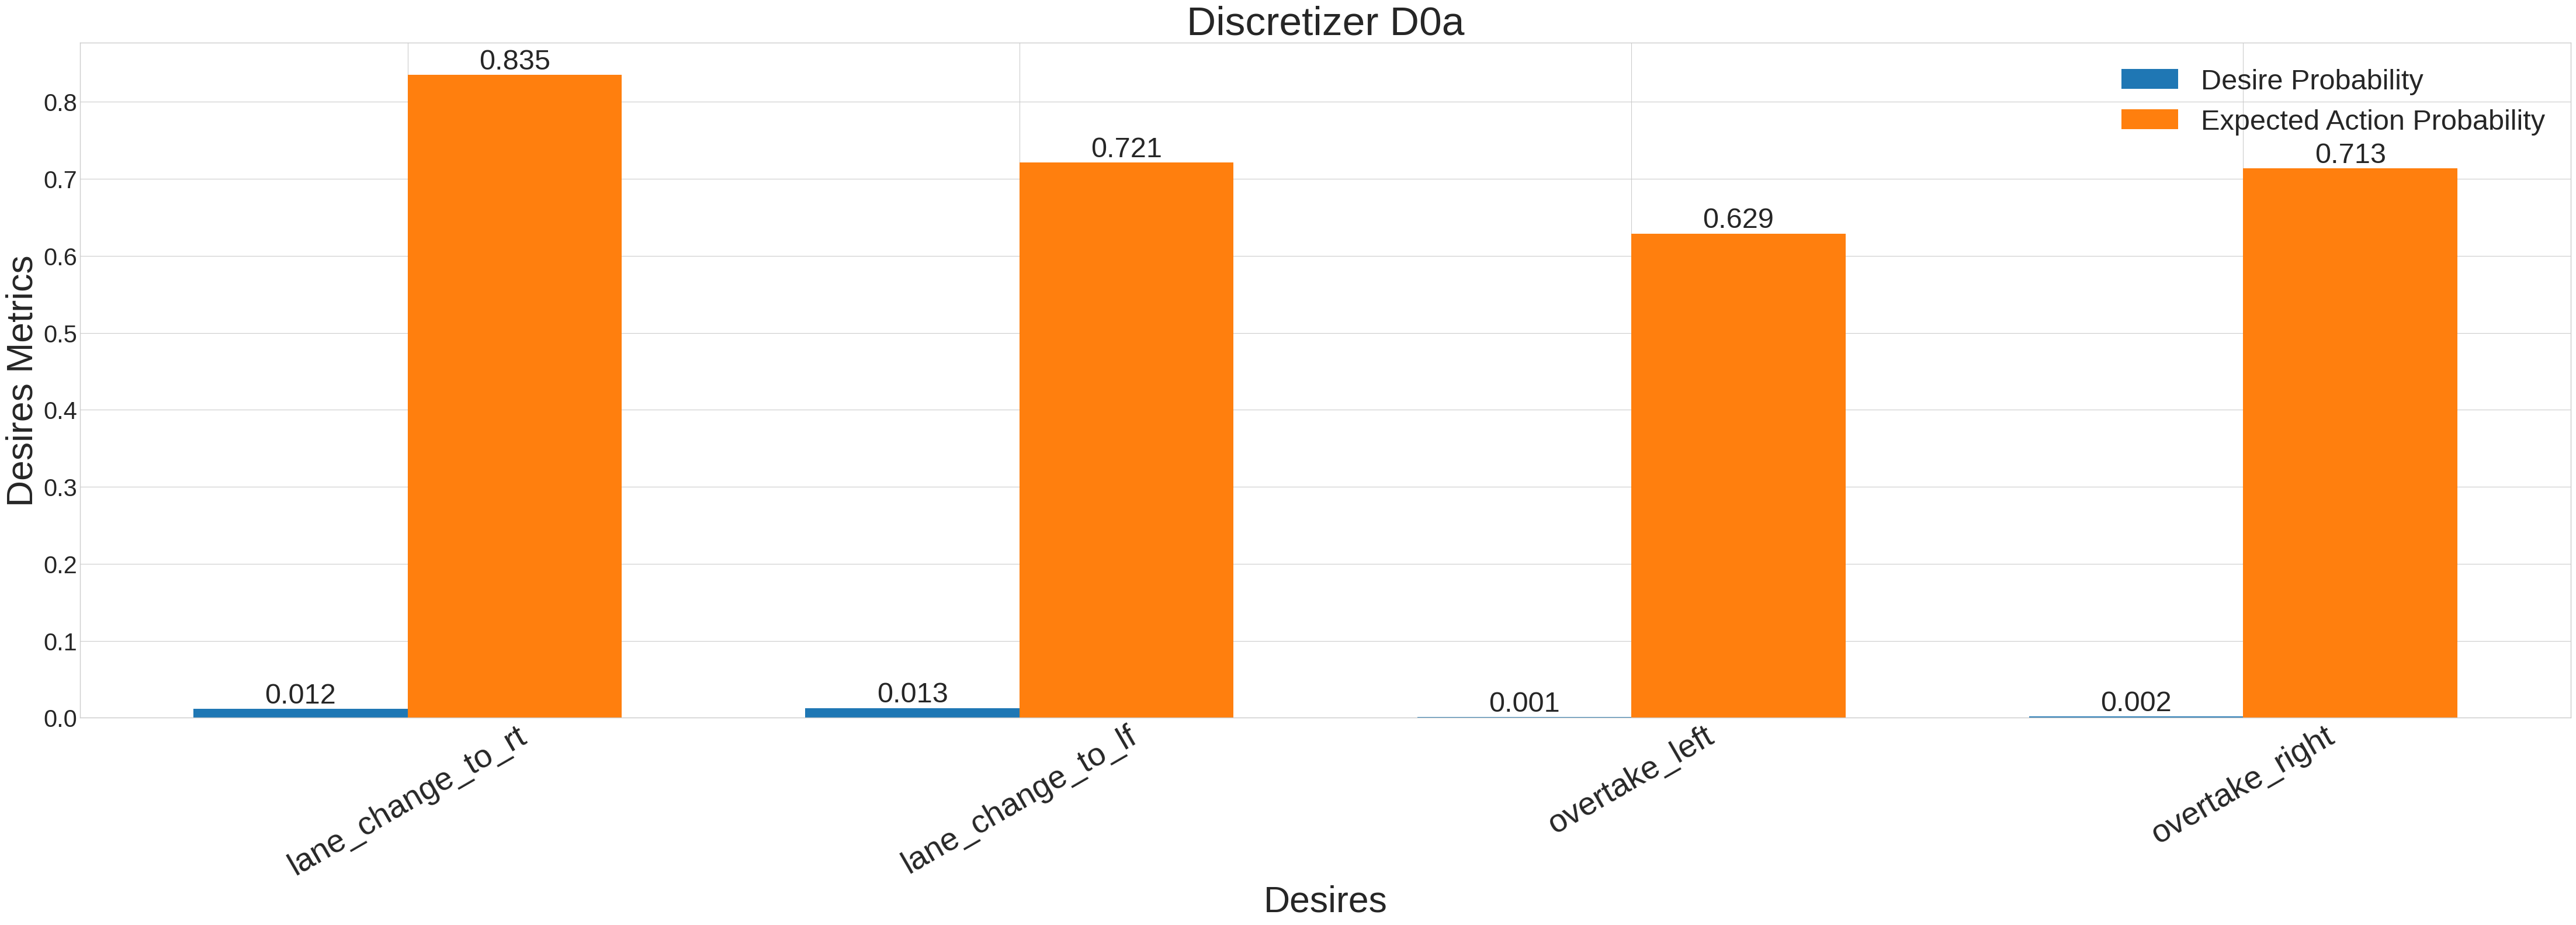

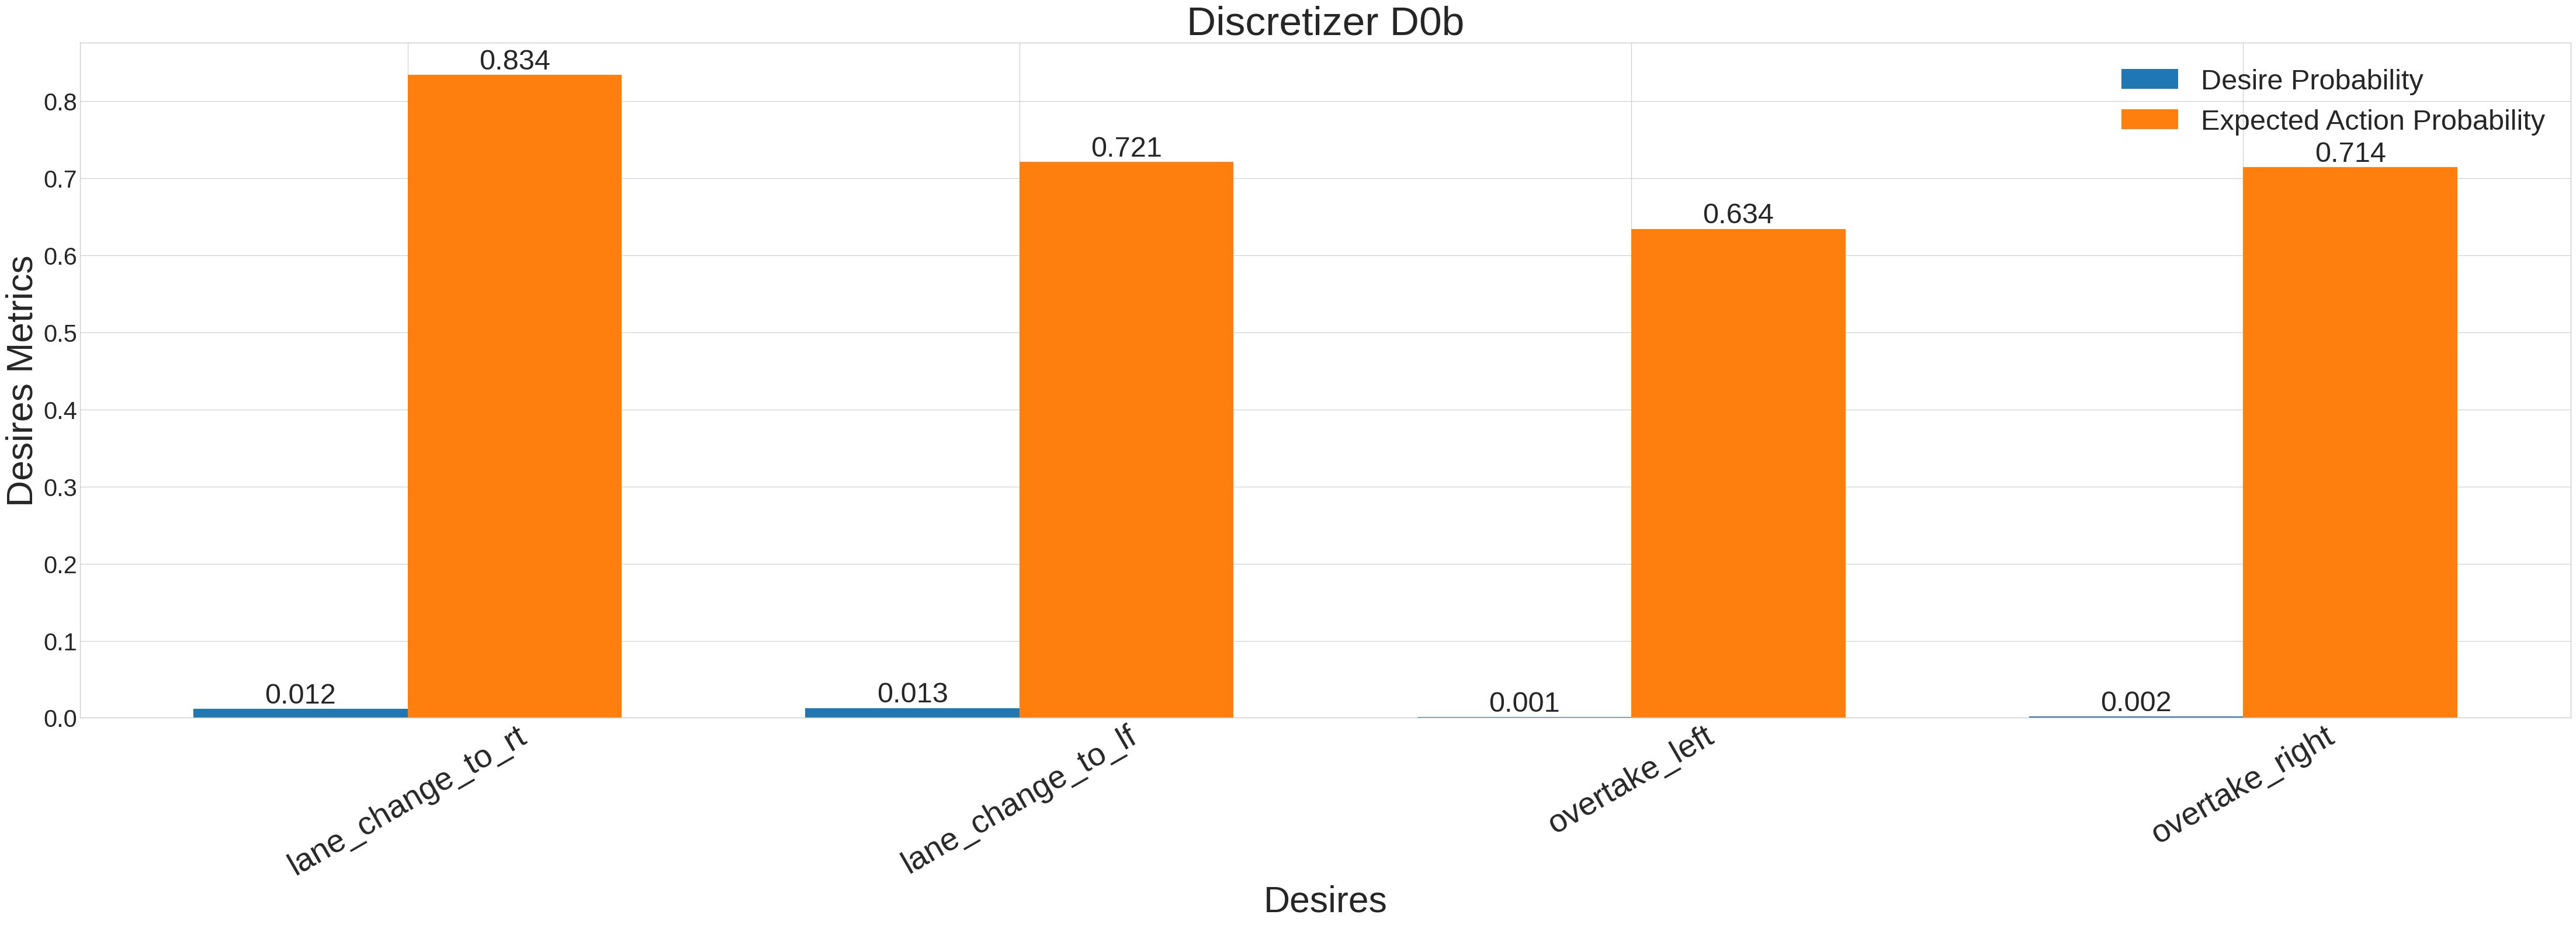

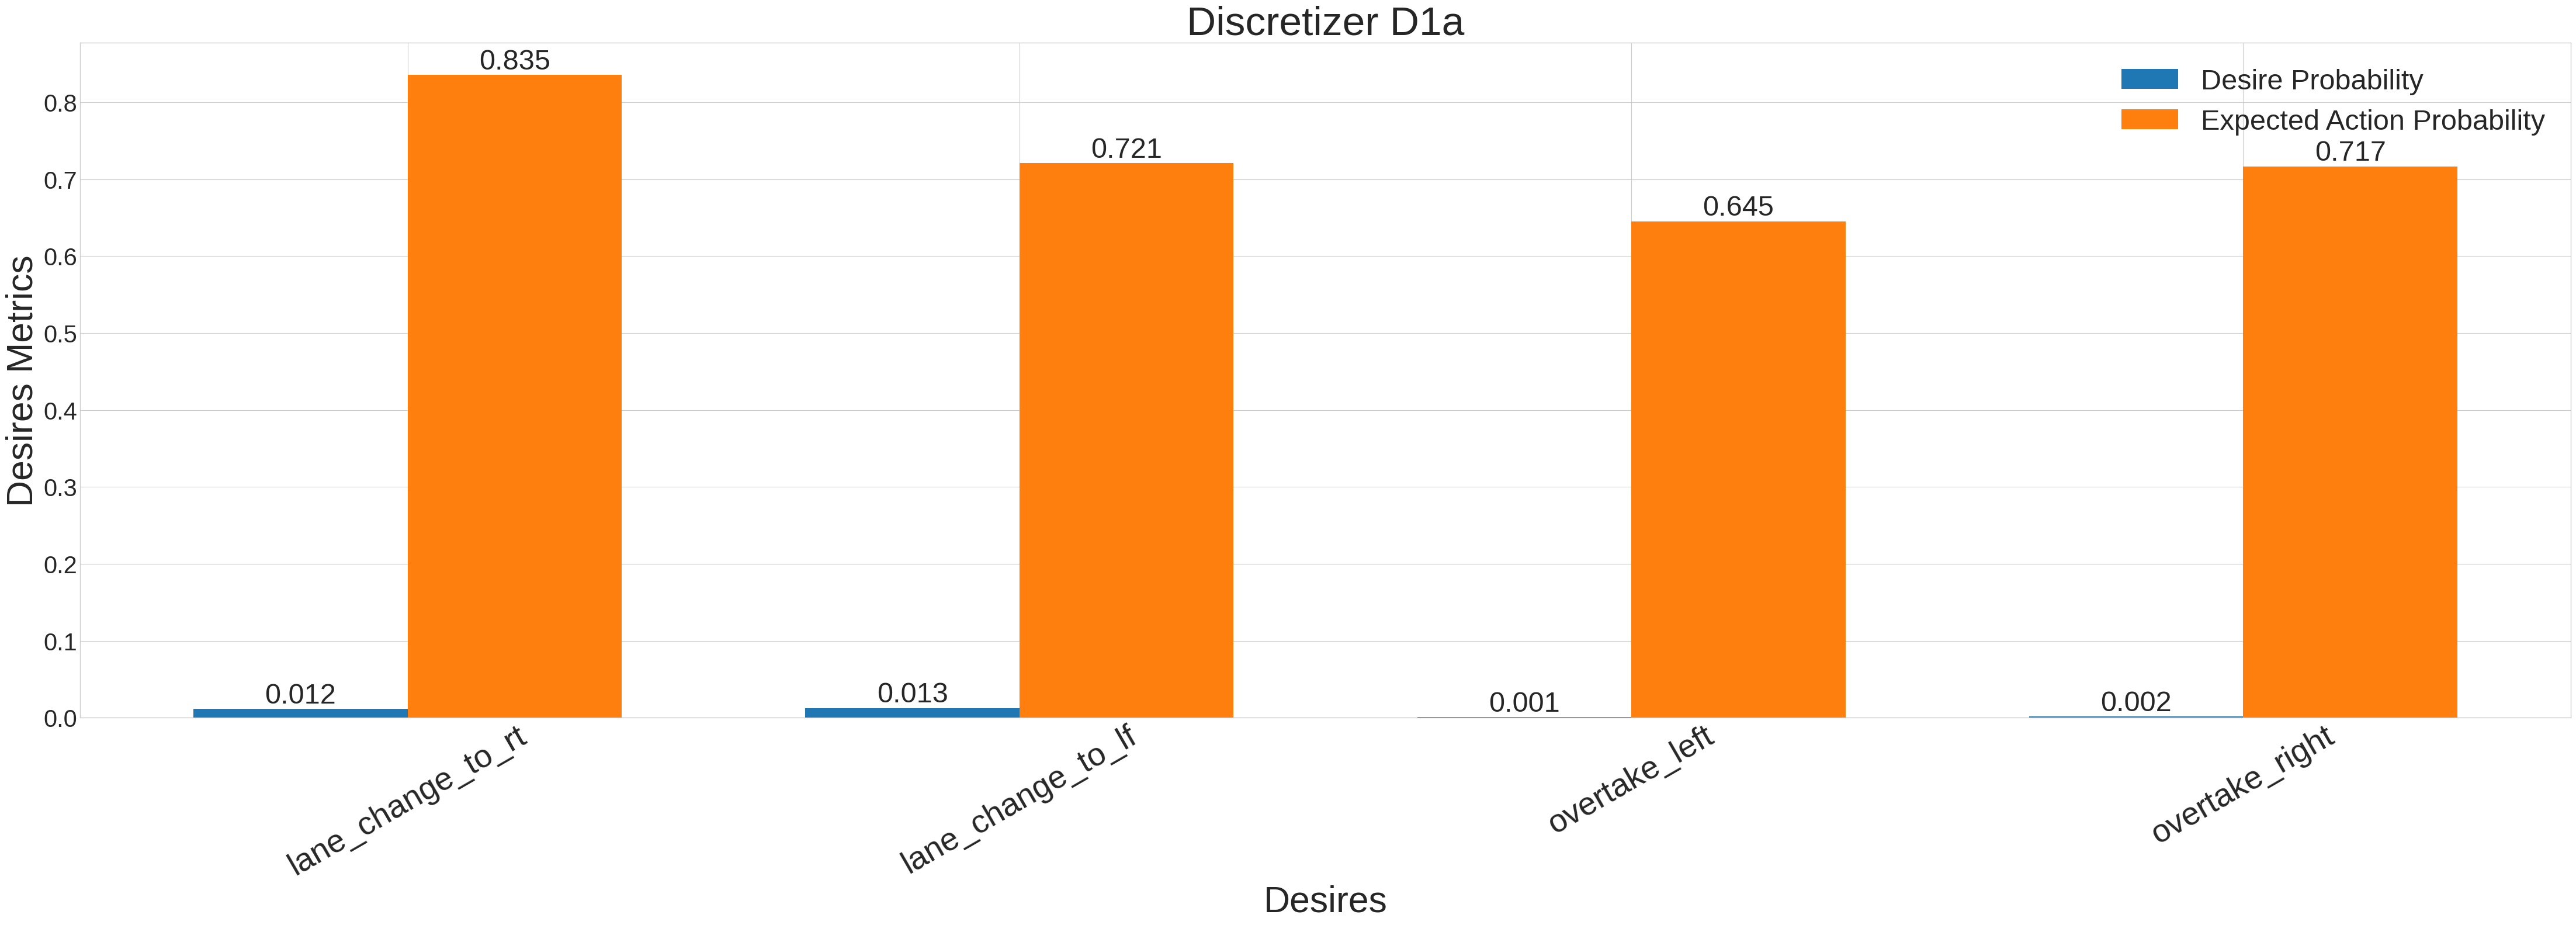

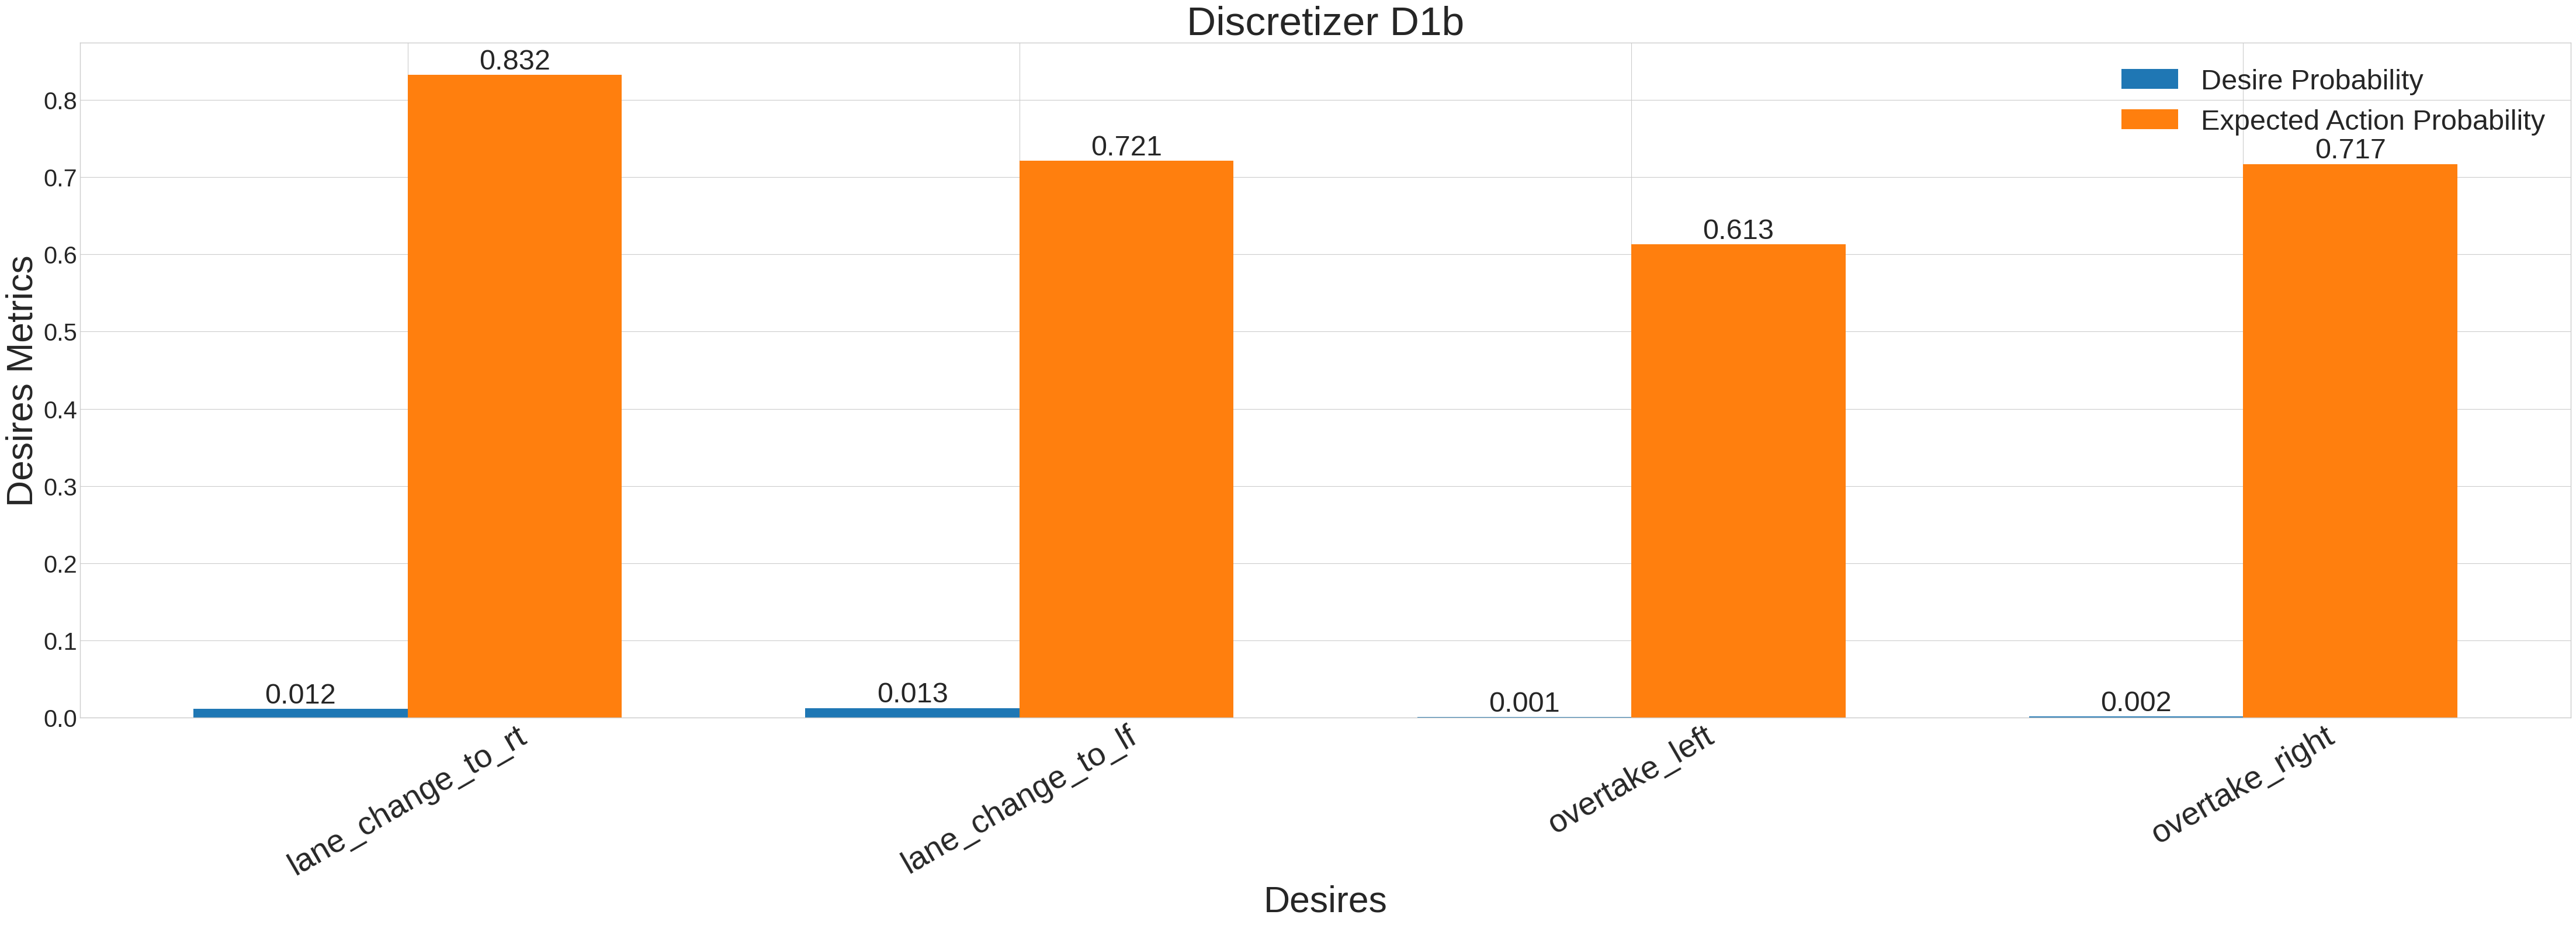

In [74]:
for discretizer in desires_data.keys():
    show_metrics(desires_data[discretizer], discretizer, type = 'Desire')


arruve at traffuc light has low exp action probability sicnce if its green we tipycally do not slow down.

#### Intentions

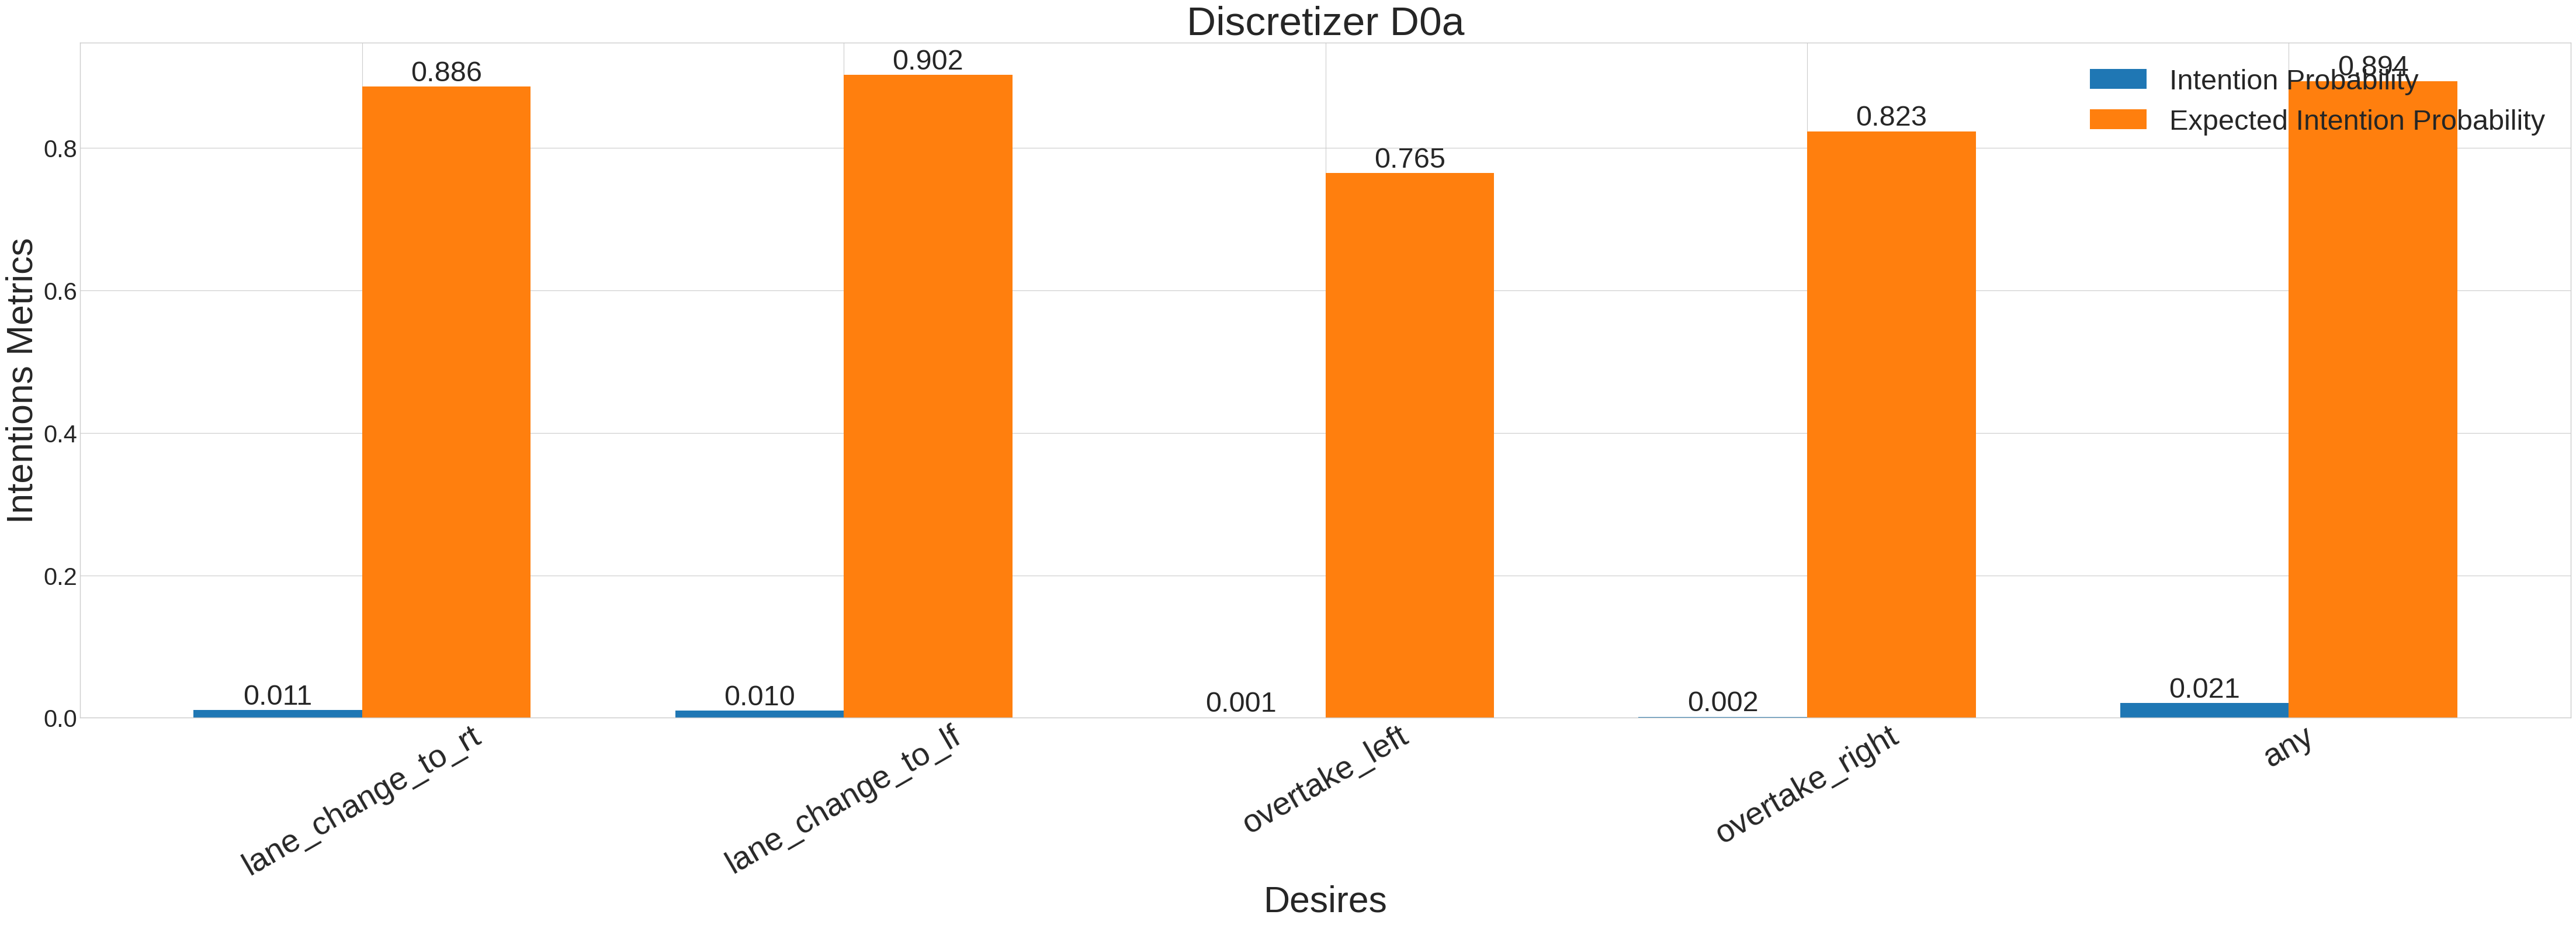

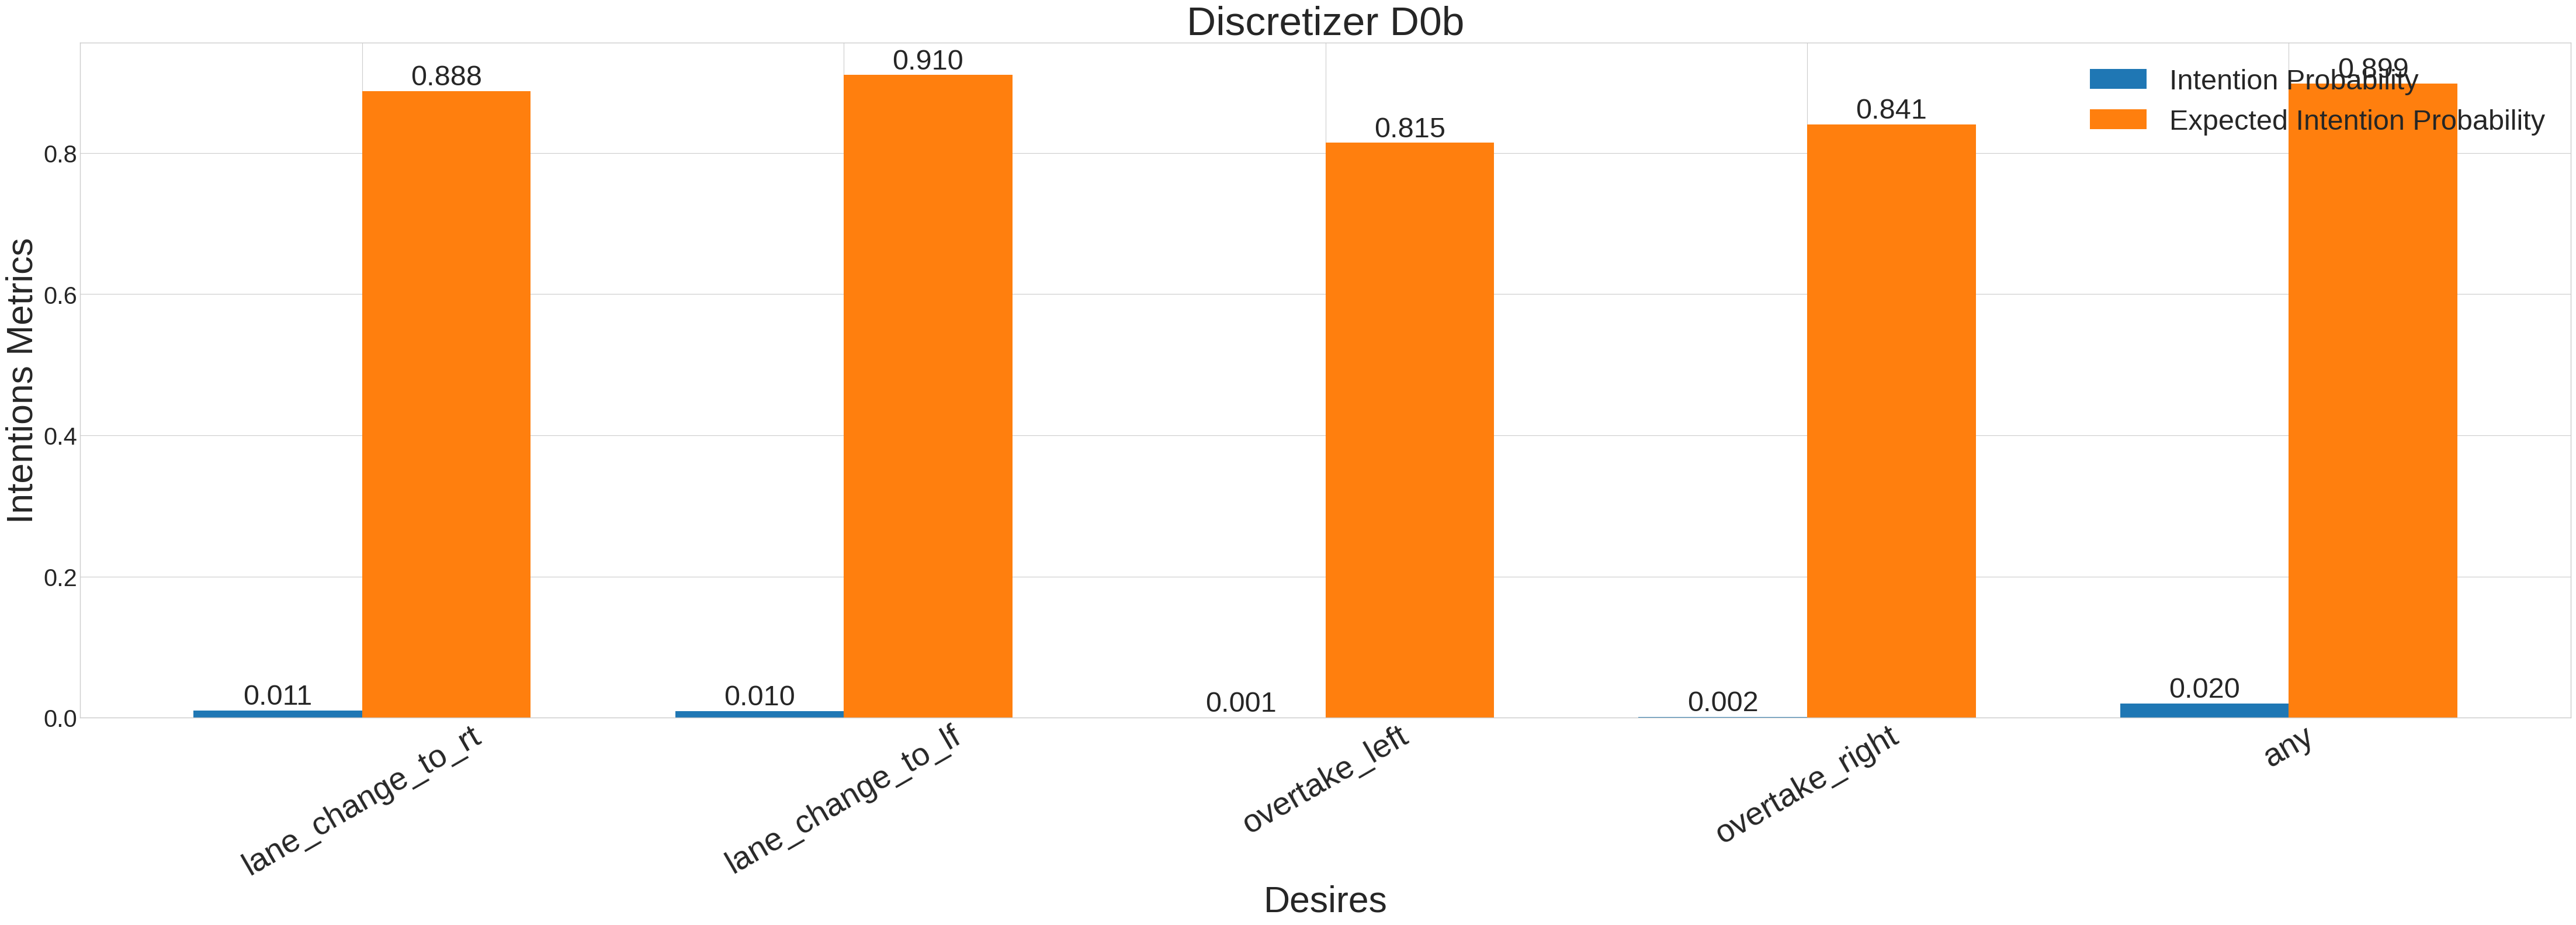

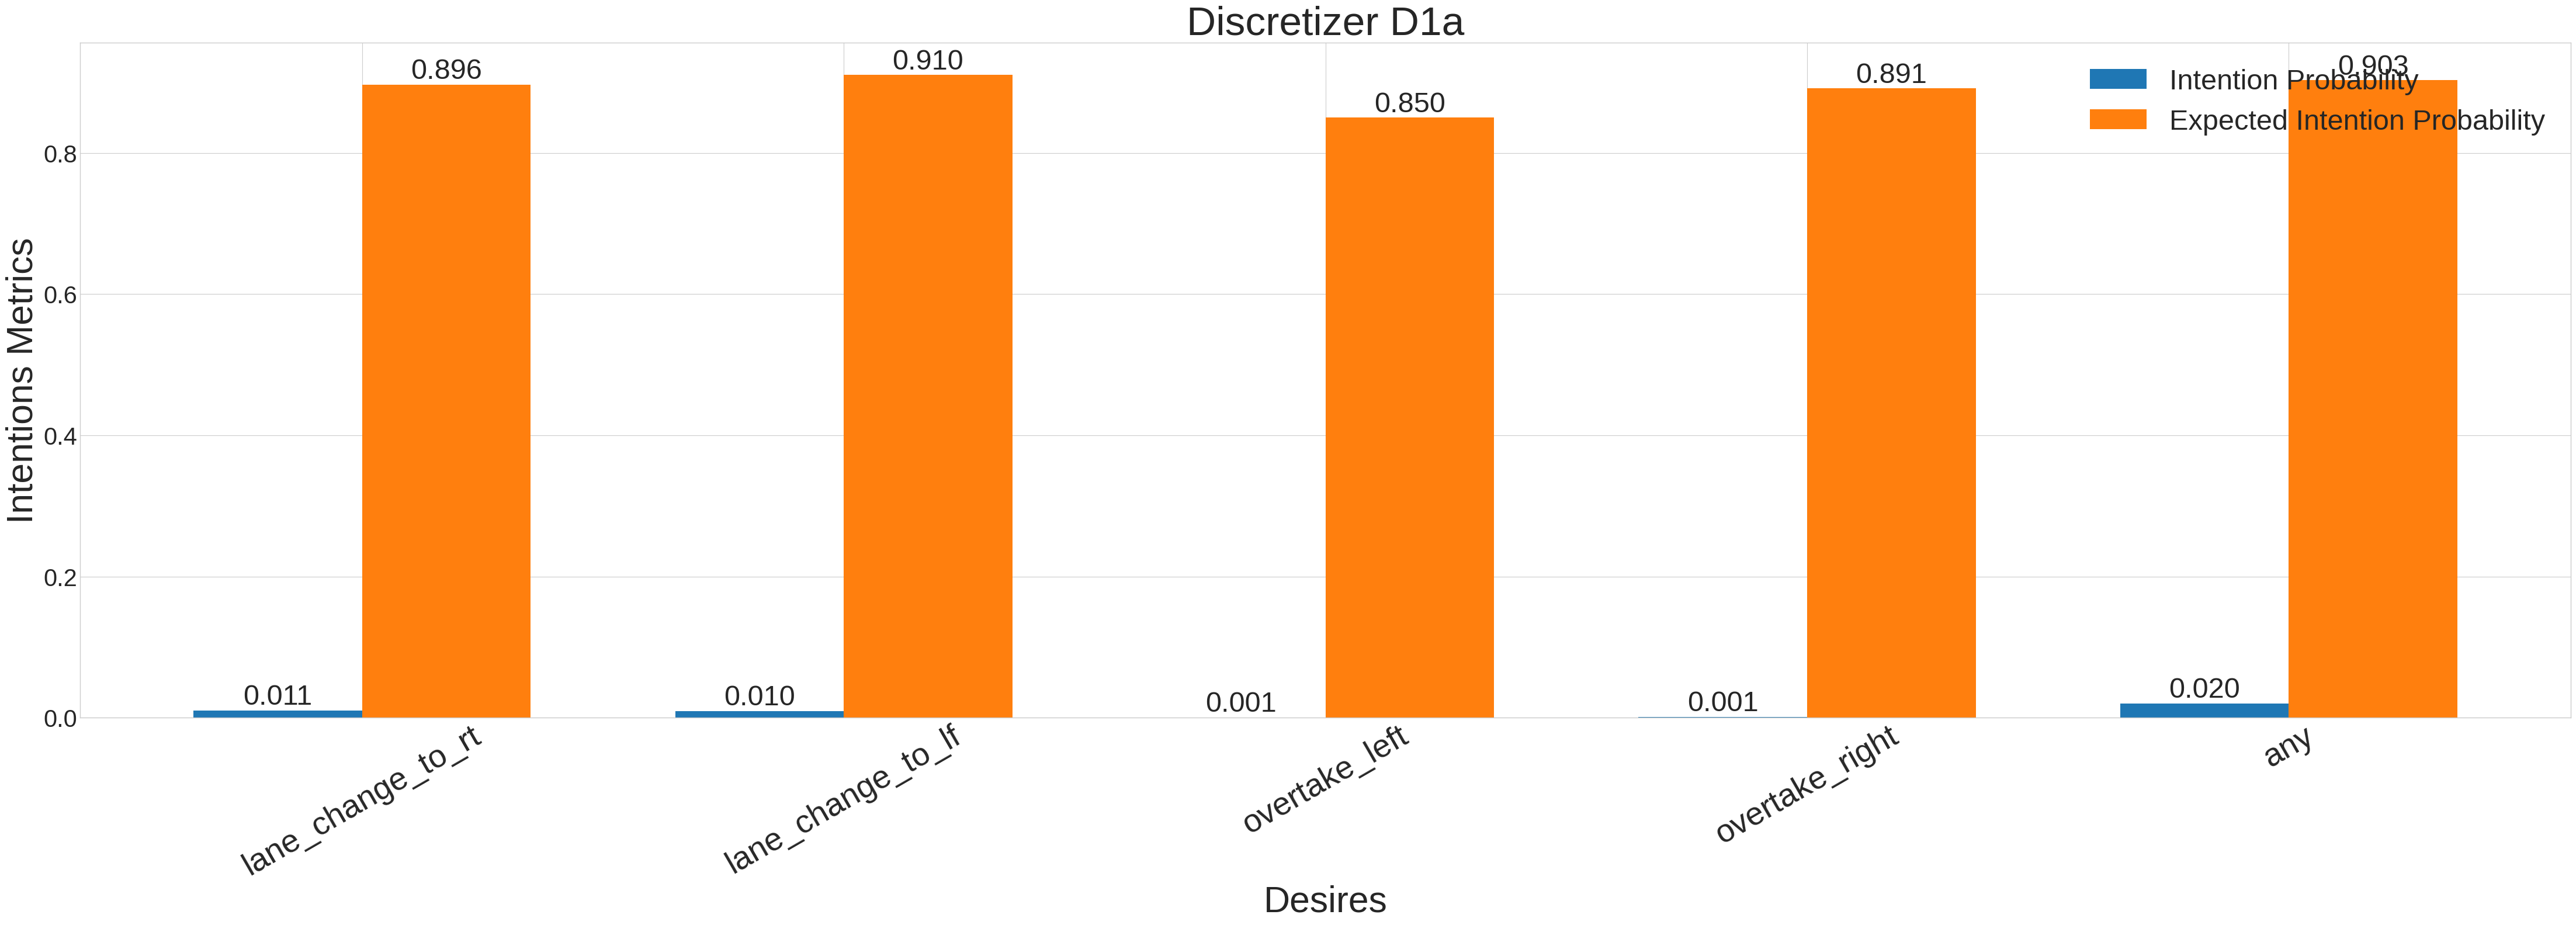

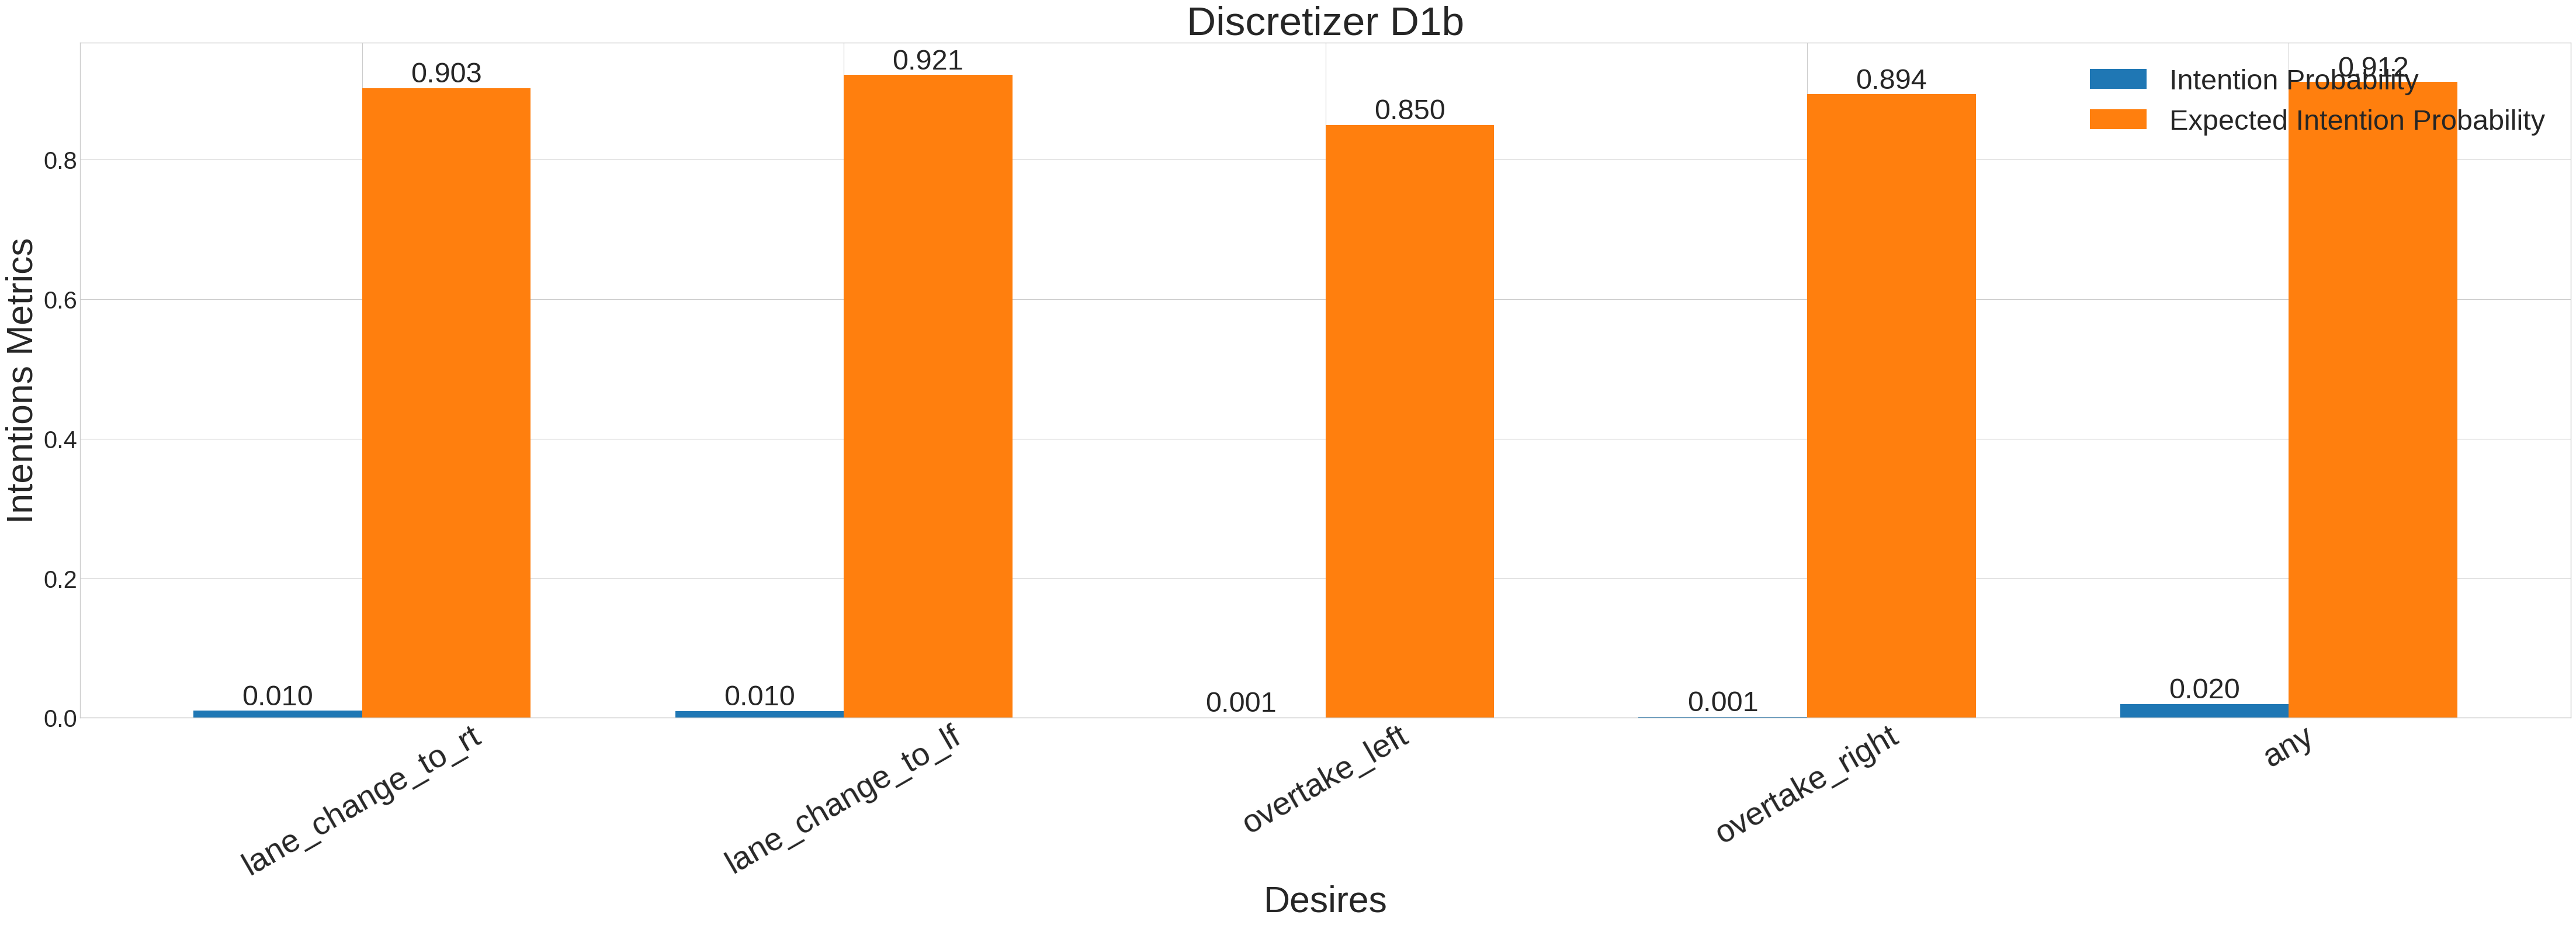

In [75]:
for discretizer in intentions_data.keys():
    show_metrics(intentions_data[discretizer], discretizer, type = 'Intention')

## ROC Curve


Choose the discretiser with higher AIC, that is, the discretiser where the interpretability vs reliability trade-off is better

- If there is no commitment threshold in which the two metrics are decently high, it becomes apparent that the desires do not capture the agent’s behaviour. This can be either because the agent did not train correctly (making the hypothesised desires something it cannot reach) or because the agent is targeting a different set of desires. Our case is the latter. 

- The probability of manifesting intentions is low. the behaviour is not interpretable with these desires, and new ones should be considered.


After seeing seeing this, we added new desires related to OBSTACLE AVOIDANCE, which improved the AUC  for discretisers D0b and D0c.

In [60]:
discretizers_info = {}
for discretizer_id in ['0a','0b','1a','1b']:
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break

    DiscretizerClass = AVDiscretizer if '0' in discretizer_id else AVDiscretizerD1
    discretizer = DiscretizerClass(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
            ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    
    discretizers_info[discretizer_id] = (pg, desires)


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
The AUC for Discretizer D0a is: -0.0493
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
The AUC for Discretizer D0b is: -0.1435
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
The AUC for Discretizer D1a is: -0.1111
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
The AUC for Discretizer D1b is: -0.1685


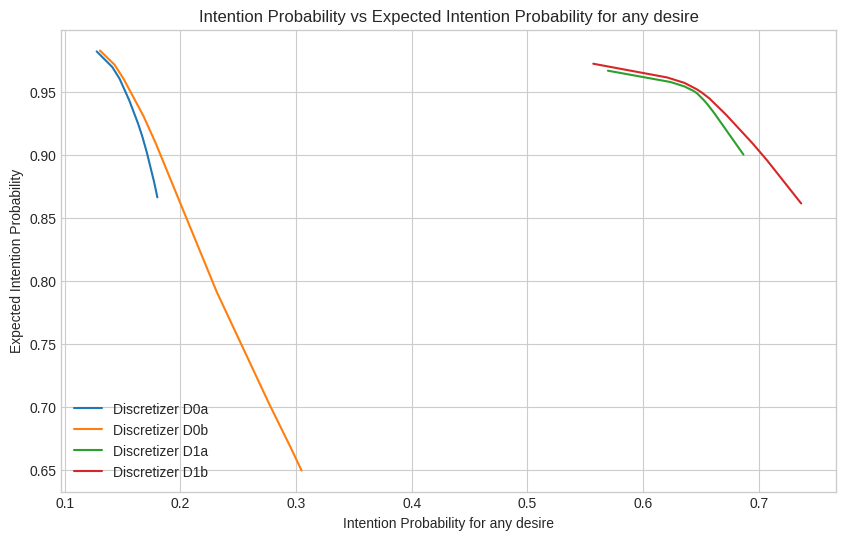

In [61]:
roc_curve(discretizers_info)